In [1]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.stats import gaussian_kde
import seaborn as sns
import SimpleITK as sitk
import glob
import os
import re
from collections import defaultdict
import nibabel as nb

In [2]:
import warnings
warnings.filterwarnings("ignore")

*this part was edited on Jan 18, 2022 to obtain result for CAL010 (decide whether or not to recollect data)

# Functions

In [30]:
#takes as input raw minc filenames, they should be ordered from lowest to greatest flip angle
def voxel_wise_lr(mtr_map_masked_concat_dict, FA_dict, mask_indices_dict):
    
    ##############################################  normalize the FA dict #######################
    FA_norm_cent_dict = {}
    
    #the first key in the dictionary contains each sub - find max FA for each sub
    for sub in FA_dict.keys():
        maxFA_per_sub = max(FA_dict[sub])
        #normalize by dividing by max flip angle, and center at 0 by subtracting 1
        FA_norm_cent_dict[sub] = (FA_dict[sub].reshape(-1,1)/maxFA_per_sub)-1

    ########################################### linear regression ###############################
    #create an empty dict to hold the slopes mtrix for each sub
    slopes_dict = {}
    
    #perform the linear regression by looping over all voxels in mask- is there no way to do this in parallel?
    #for each voxel, add the slope from the linear regression to the slopes array
    for sub in FA_dict.keys():
        #extract info from mask
        original_3d_shape = mask_indices_dict[sub].shape
        numvox_in_mask = mtr_map_masked_concat_dict[sub].shape[0]
        slopes = np.zeros((numvox_in_mask,))
        
        for i in range(0, numvox_in_mask):
            mtr_norm_across_FA = np.array([])
            regr_obj = linear_model.LinearRegression(fit_intercept = False)
            regr_fit = regr_obj.fit(FA_norm_cent_dict[sub], mtr_map_masked_concat_dict[sub][i,:])
            slopes[i] = regr_fit.coef_
            
        #recover the 3D matrix format using mask information
        slopes_matrix = np.zeros(original_3d_shape)
        slopes_matrix[mask_indices_dict[sub]] = slopes
        slopes_dict[sub] = slopes_matrix
        slopes = np.zeros((numvox_in_mask,))
    
    return slopes_dict, FA_norm_cent_dict

# Load data

In [4]:
#these maps were created on jan 18 with cal010 data because it was the only one with consistent RG. B1 maps were weird though.
#they are from the cic folder /data/scratch/mila/2021_mtr/part2_derive_B1_correction/2_derivatives/mtr_maps/mtr_maps_denoised_normalized_masked
mtr_map_files = glob.glob("../files_for_code/b1_mtr_relationship_mtr_maps_in_mt1_space/*mtr_map*")
mask_files = glob.glob("../files_for_code/b1_mtr_relationship_mtr_maps_in_mt1_space/*mask*")

# Preprocess and extract info

In [5]:
#create dictionaries that can have two keys (one for sub and one for FA)
mtr_map_dict = defaultdict(dict)
mtr_map_masked_concat_dict = {}
mtr_arrays_to_fill_dict = {}
FA_dict = {}
mask_indices_dict = {}
numvox_dict = {}

#process all the masks (one per sub)
for file in range (0,len(mask_files)):
    #extract subject ID from name
    file_name = os.path.basename(mask_files[file])
    sub = re.search('sub-(.*)_acq', file_name).group(1)
    
    #convert the mncs to arrays
    mask_arr = sitk.GetArrayFromImage(sitk.ReadImage(mask_files[file]))
    vol_indices = mask_arr.astype(bool)
    numvox = mask_arr[vol_indices].shape[0]

    #store the information (the mask array, the boolean indices and the num of voxels)
    mask_indices_dict[sub] = vol_indices
    numvox_dict[sub] = numvox
    
    #also, store empty arrays for the concatenated mtr maps (since there is one per sub) in a dict
    mtr_arrays_to_fill_dict[sub] = np.empty((numvox, 0))

#create arrays that will be filled for each FA
FA_array_per_sub = np.array([])
prev_sub = 'CAL010'

#process all the mtr maps (multiple per sub)
for file in range (0,len(mtr_map_files)):
    
    #extract subject ID and FA from name
    file_name = os.path.basename(mtr_map_files[file])
    sub = re.search('sub-(.*)_acq', file_name).group(1)
    FA = re.search('flip-(.*)_MTw', file_name).group(1)
    FA_to_store = int(FA)
    
    #convert the mncs to arrays
    mtr_map_arr = sitk.GetArrayFromImage(sitk.ReadImage(mtr_map_files[file]))
    
    #process mincs by masking and centering them
    mtr_map_arr_masked_centered = np.expand_dims(mtr_map_arr[mask_indices_dict[sub]], axis = 1) - 1
    mtr_map_dict[sub][FA] = mtr_map_arr
    
    #concatenate the flat, masked mtr map to the previous map along the second dimension (if the sub is the same)
    if (prev_sub == sub) | (file == 0):
        mtr_arrays_to_fill_dict[sub] = np.append(mtr_arrays_to_fill_dict[sub], mtr_map_arr_masked_centered, axis = 1)
        FA_array_per_sub = np.append(FA_array_per_sub, FA_to_store)
        
    if (prev_sub != sub) | (file == (len(mtr_map_files)-1)):
        #if a new sub, then add the final mtr_map_concat to df, and reinitialize a new one
        mtr_map_masked_concat_dict[prev_sub] = mtr_arrays_to_fill_dict[prev_sub]
        FA_dict[prev_sub] = FA_array_per_sub
        FA_array_per_sub = FA_to_store
    
    prev_sub = sub

# Run the voxelwise linear regression

In [31]:
voxel_wise_lr_slopes_matrix, FA_norm_cent_dict = voxel_wise_lr(mtr_map_masked_concat_dict, FA_dict, mask_indices_dict)

<function matplotlib.pyplot.show(close=None, block=None)>

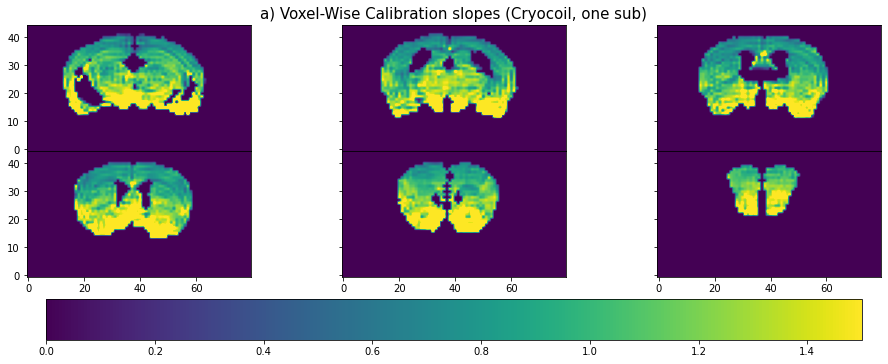

In [32]:
#plot the results
fig, axs = plt.subplots(2, 3, figsize=(16,5), sharey = True, sharex = True)
vmax_val = 1.5
pic1_d_e = axs[0,0].imshow(voxel_wise_lr_slopes_matrix['CAL010'][:, 40, :], vmin=0, vmax=vmax_val, origin = 'lower')
pic1_d_e = axs[0,1].imshow(voxel_wise_lr_slopes_matrix['CAL010'][:, 45, :], vmin=0, vmax=vmax_val, origin = 'lower')
pic1_d_e = axs[0,2].imshow(voxel_wise_lr_slopes_matrix['CAL010'][:, 50, :], vmin=0, vmax=vmax_val, origin = 'lower')

pic1_d_e = axs[1,0].imshow(voxel_wise_lr_slopes_matrix['CAL010'][:, 55, :], vmin=0, vmax=vmax_val, origin = 'lower')
pic1_d_e = axs[1,1].imshow(voxel_wise_lr_slopes_matrix['CAL010'][:, 60, :], vmin=0, vmax=vmax_val, origin = 'lower')
pic1_d_e = axs[1,2].imshow(voxel_wise_lr_slopes_matrix['CAL010'][:, 65, :], vmin=0, vmax=vmax_val, origin = 'lower')


fig.colorbar(pic1_d_e, ax=axs, orientation='horizontal')
plt.subplots_adjust(bottom = 0.3, top = 1, hspace=0.001)
axs[0,1].set_title('a) Voxel-Wise Calibration slopes (Cryocoil, one sub)', fontsize = 15)
plt.show

# Run the overall linear regression

In [34]:
FA_norm_cent_dict

{'CAL010': array([[-0.0430622],
        [ 0.       ],
        [-0.215311 ],
        [-0.1722488],
        [-0.1291866],
        [-0.0861244]])}

## Version 1: regress one line over all MTR values per FA

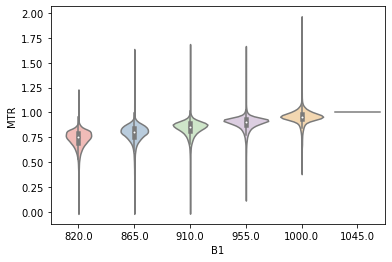

In [79]:
b1_arr = np.repeat(FA_dict['CAL010'],numvox_dict['CAL010'])
mtr_arr = np.ndarray.flatten(mtr_map_masked_concat_dict['CAL010'], 'F')
df = pd.DataFrame({'B1':b1_arr, 'MTR':mtr_arr+1})
plt.figure()
sns.violinplot(x="B1", y="MTR", data=df, palette="Pastel1")
plt.show()

In [39]:
regr_obj = linear_model.LinearRegression(fit_intercept = False)
regr_fit = regr_obj.fit(mtr_map_masked_concat_dict['CAL010'][:,:].transpose(), FA_norm_cent_dict['CAL010'])
slope_across_all_voxels = regr_fit.coef_
slope_across_all_voxels.shape

(1, 33409)

In [50]:
regr_obj = linear_model.LinearRegression(fit_intercept = False)
regr_fit = regr_obj.fit(np.repeat(FA_norm_cent_dict['CAL010'],numvox_dict['CAL010'], axis = 1)
                        , mtr_map_masked_concat_dict['CAL010'][:,:].transpose())
slope_across_all_voxels = regr_fit.coef_
slope_across_all_voxels.shape

KeyboardInterrupt: 

In [45]:
np.repeat(FA_norm_cent_dict['CAL010'],numvox_dict['CAL010'], axis = 1).shape

(6, 33409)

## Version 2: Regress one line over the mean MTR per FA

In [55]:
regr_obj = linear_model.LinearRegression(fit_intercept = False)
regr_fit = regr_obj.fit(FA_norm_cent_dict['CAL010'], np.mean(mtr_map_masked_concat_dict['CAL010'], axis = 0))
slope_across_means = regr_fit.coef_
slope_across_means

array([1.22319507])

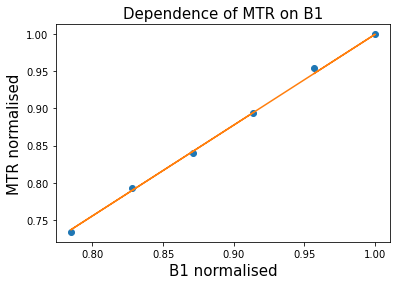

In [58]:
#plot all average mtr value inside mask, at each FA 
plt.figure()
plt.plot(FA_norm_cent_dict['CAL010']+1,np.mean(mtr_map_masked_concat_dict['CAL010']+1, axis = 0), 'o')
plt.plot(FA_norm_cent_dict['CAL010']+1, slope_across_means*(FA_norm_cent_dict['CAL010'])+1)
plt.ylabel('MTR normalised', fontsize = 15)
plt.xlabel('B1 normalised', fontsize = 15)
plt.title('Dependence of MTR on B1', fontsize = 15)
plt.show()